In [1]:
#!/usr/bin/env python3.4

import os
import sys
import re
import cv2
import uuid
import random
import imageio
import numpy as np
import torch
import torch_scatter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

# torch.multiprocessing.set_start_method(method='spawn', force=True)

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
sys.path.append('../')

from scipy import misc
from PIL import Image
from tqdm import tqdm
from omegaconf import OmegaConf, DictConfig
from evaluation import eval_utils as eu

/tmp/ipykernel_64610/1628265454.py:22: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc


## 0. Data loading

In [2]:
output_dir = "../workdir/sceneflow/sceneflow_highres_sky_lmr_0.2_gmr_0.1_vox_None"
config = OmegaConf.load(os.path.join(output_dir, 'config.yaml'))

if config.data.scene_type.lower() == "sceneflow":
    from utils.dataparsers import SceneFlowDataParser
    config.data.data_dir = os.path.join('../', config.data.data_dir)  # update relative path for notebook
    data_parser = SceneFlowDataParser(config.data, config.device, dtype=torch.float32)
    data_parser.voxel_size, data_parser.use_raft = 0.01, False
    frame_ids = eu.get_frame_ids(config.generation.frame_range, config.generation.frame_ids)
    org_frames, _, _, flows, past_flows =  data_parser.load_video(frame_ids)
else:
    raise NotImplementedError(f"Scene type {config.data.scene_type} is not supported.")

/data1/jing_li/anaconda3/envs/iclight-bkup/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Reading camera data: 100%|██████████| 300/300 [00:00<00:00, 130881.13it/s]


[INFO] frame indexes:  0 1 ... 298 299


Loading Data: 100%|██████████| 300/300 [00:07<00:00, 40.28it/s]


[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)
[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)


Loading Flows: 100%|██████████| 300/300 [00:01<00:00, 163.96it/s]
/data1/jing_li/anaconda3/envs/iclight-bkup/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)
[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)


Assigning flow ids: 100%|██████████| 299/299 [00:00<00:00, 850.01it/s]


[INFO] Scatter with Time&Spatial Dimention.
Total number of unique voxels: 91533549 / 147456000


## 2. Optimization

In [10]:
def encode_imgs(vae, imgs):
    # with torch.autocast(device_type=data_parser.device, dtype=torch.float16):
    imgs = 2 * imgs - 1
    posterior = vae.encode(imgs).latent_dist
    latents = posterior.mode() * 0.18215
    return latents

def decode_latents(vae, latents):
    # with torch.autocast(device_type=data_parser.device, dtype=torch.float16):
    latents = 1 / 0.18215 * latents
    imgs = vae.decode(latents).sample
    imgs = (imgs / 2 + 0.5).clamp(0, 1)
    return imgs

In [4]:
import datetime
from torch import nn
from torchvision.transforms.functional import rgb_to_grayscale
from plugin.VidToMe.utils import save_video
from utils.sh_utils import RGB2SH, SH2RGB, eval_sh
from utils.general_utils import get_expon_lr_func
from utils.loss_utils import l1_loss, relaxed_ms_ssim, depth_loss_dpt, VGGPerceptualLoss
from utils.flow_utils import warp_flow, compute_fwdbwd_mask, get_mask_bwds
from utils.dataloader import OptDataset

# vgg_loss = VGGPerceptualLoss(resize=False)
max_sh_degree = 3
lambda_dssim = 0.2
lambda_perceptual = 0.01
lambda_depth = 0.2
lambda_flow = 0.8
lambda_exp = 0.8
epochs_exposure = 35
epochs = 70
batch_size = 1
iterations = epochs_exposure * len(frame_ids) // batch_size

feature_lr = 0.05 * batch_size / len(frame_ids)
exposure_lr_init = 0.01
exposure_lr_final = 0.001
exposure_lr_delay_steps = 0
exposure_lr_delay_mult = 0.0

In [5]:
mask_bwds = get_mask_bwds(org_frames, flows, past_flows)

pil_list = eu.video_to_pil_list(f'{output_dir}/output.gif')
edited_images = torch.concat([eu.load_image(pil, flows.device, flows.dtype) for pil in pil_list], dim=0) / 255.0
N, _, H, W = edited_images.shape

dataset = OptDataset(
    edited_images,
    past_flows,
    mask_bwds,
    device=data_parser.device
)

data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True
)

del edited_images, pil_list, mask_bwds, flows, past_flows

In [6]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
start_time = datetime.datetime.now()

loss_list_exposure = []
pbar = tqdm(total=epochs_exposure, desc="Optimizing Exposures")

exposure = nn.Parameter(torch.eye(3, 4, device="cuda")[None].repeat(len(frame_ids), 1, 1).requires_grad_(True))
exposure_optimizer = torch.optim.Adam([exposure])
exposure_scheduler_args = get_expon_lr_func(exposure_lr_init, exposure_lr_final,
                                            lr_delay_steps=exposure_lr_delay_steps,
                                            lr_delay_mult=exposure_lr_delay_mult,
                                            max_steps=iterations)

for epoch in range(epochs_exposure):
    for i, (idxs, _edited_images, _pre_edited_images, _past_flows, _mask_bwds) in enumerate(data_loader):

        iteration = epoch * len(frame_ids) // batch_size + i + 1
        for param_group in exposure_optimizer.param_groups:
            param_group['lr'] = exposure_scheduler_args(iteration)

        cat_images = torch.cat([_edited_images, _pre_edited_images], dim=0)
        cat_idxs = torch.cat([idxs, idxs-1], dim=0)
        cat_idxs[cat_idxs < 0] = 0

        cat_images = torch.bmm(cat_images.permute(0, 2, 3, 1).reshape(-1, H*W, 3), exposure[cat_idxs, :3, :3]) + exposure[cat_idxs, None, :3, 3]
        cat_images = torch.clamp(cat_images, 0, 1).reshape(-1, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

        images = cat_images[:len(idxs)]
        pre_images = cat_images[len(idxs):]

        loss_photometric = l1_loss(images, _edited_images) * (1 - lambda_dssim) + \
                            (1.0 - relaxed_ms_ssim(images, _edited_images, data_range=1, start_level=1)) * lambda_dssim

        warped_images = warp_flow(pre_images, _past_flows)[idxs>0]
        images, _mask_bwds = images[idxs>0], _mask_bwds[idxs>0]

        loss_flow = l1_loss(warped_images[_mask_bwds], images[_mask_bwds])

        loss = (1 - lambda_exp) * loss_photometric + lambda_exp * loss_flow

        loss_list_exposure.append(loss.item())

        loss.backward()

        exposure_optimizer.step()
        exposure_optimizer.zero_grad(set_to_none = True)
    
    pbar.set_postfix(
        loss='{:3f}'.format(loss.item()), 
        loss_flow='{:3f}'.format(loss_flow.item()),
        loss_photometric='{:3f}'.format(loss_photometric.item())
    )
    pbar.update()

pbar.close()

dataset.exposure_align(exposure)

end_time = datetime.datetime.now()
max_memory_allocated = torch.cuda.max_memory_allocated() / (1024.0 ** 2)
print(f"Memory: {max_memory_allocated:.2f} MB")
print(f"Time: {(end_time - start_time).total_seconds()}s")

Optimizing Exposures:   0%|          | 0/35 [00:00<?, ?it/s]

Optimizing Exposures: 100%|██████████| 35/35 [04:36<00:00,  7.90s/it, loss=0.058907, loss_flow=0.045625, loss_photometric=0.112031]

Memory: 14544.47 MB
Time: 276.667534s


In [7]:
from diffusers import AutoencoderKL
from diffusers.models.attention_processor import AttnProcessor2_0
vae = AutoencoderKL.from_pretrained('stablediffusionapi/realistic-vision-v51', subfolder="vae")
vae = vae.to(device=data_parser.device, dtype=data_parser.dtype)
vae.set_attn_processor(AttnProcessor2_0())

# frozen the parameters of vae
for param in vae.parameters():
    param.requires_grad = False

In [11]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
start_time = datetime.datetime.now()
pbar.close()

with torch.no_grad():
    latents = []
    for i in tqdm(range(0, len(frame_ids), batch_size), desc="Latents Extraction"):
        batch = dataset.edited_images[i:i+batch_size]
        latents.append(encode_imgs(vae, batch))
    latents = torch.cat(latents, dim=0)
    
latent_feats = nn.Parameter(latents.contiguous().requires_grad_(True))

l = [
    {'params': [latent_feats], 'lr': feature_lr, "name": "latent"},
]
optimizer = torch.optim.Adam(l, lr=0.0, eps=1e-15)

loss_list = []

pbar = tqdm(total=iterations, desc="Optimizing Unique Tensor")

for epoch in range(epochs):
    for i, (idxs, _edited_images, _, _past_flows, _mask_bwds) in enumerate(data_loader):

        # iteration = epoch * len(frame_ids) // batch_size + i + 1
        _mask_bwds = _mask_bwds[idxs>0]
        cat_idxs = torch.cat([idxs, idxs-1], dim=0)
        cat_idxs[cat_idxs < 0] = 0

        cat_images = decode_latents(vae, latent_feats[cat_idxs])

        images = cat_images[:len(idxs)].to(_past_flows.dtype)
        pre_images = cat_images[len(idxs):].to(_past_flows.dtype)

        warped_images = warp_flow(pre_images, _past_flows)
        
        loss_flow = l1_loss(warped_images[idxs>0][_mask_bwds], images[idxs>0][_mask_bwds])
        
        # 0. original
        loss_photometric = (1.0 - relaxed_ms_ssim(images, _edited_images, data_range=1, start_level=1)) * lambda_dssim

        # 1. quantize images to relax the restriction
        # loss_ssim = (1.0 - ms_ssim(images, _edited_images, data_range=1)) * lambda_dssim
        # loss_ssim_org = (1.0 - ms_ssim(rgb_to_grayscale(images), rgb_to_grayscale(org_images[idxs]), data_range=1)) * lambda_dssim * 0.2
        # loss_photometric = loss_ssim + loss_ssim_org

        # 2. weight the ssim loss with per-image confidence
        # loss_photometric = ((1.0 - relaxed_ms_ssim(images, _edited_images, data_range=1, 
        #                     start_level=1, size_average=False)) * loss_weight[idxs]).mean() * lambda_dssim

        # 3. weight the ssim loss with per-pixel confidence
        # loss_photometric = (1.0 - weighted_ms_ssim(images, _edited_images, org_frames[idxs], data_range=1, start_level=1)) * lambda_dssim
        
        # 4. use perceptual loss as supervision
        # loss_photometric = vgg_loss(images, _edited_images) * lambda_perceptual

        loss = (1 - lambda_exp) * loss_photometric + lambda_exp * loss_flow

        loss_list.append(loss.item())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad(set_to_none = True)

        pbar.set_postfix(
            loss='{:3f}'.format(loss.item()), 
            loss_flow='{:3f}'.format(loss_flow.item()),
            loss_photometric='{:3f}'.format(loss_photometric.item())
        )
        pbar.update()

pbar.close()

end_time = datetime.datetime.now()
max_memory_allocated = torch.cuda.max_memory_allocated() / (1024.0 ** 2)
print(f"Memory: {max_memory_allocated:.2f} MB")
print(f"Time: {(end_time - start_time).total_seconds()}s")

Optimizing Unique Tensor:   2%|▏         | 170/10500 [01:27<1:28:20,  1.95it/s, loss=0.028695, loss_flow=0.033760, loss_photometric=0.008436]

KeyboardInterrupt: 

Text(0.5, 1.0, 'Loss curve for unique tensor optimization')

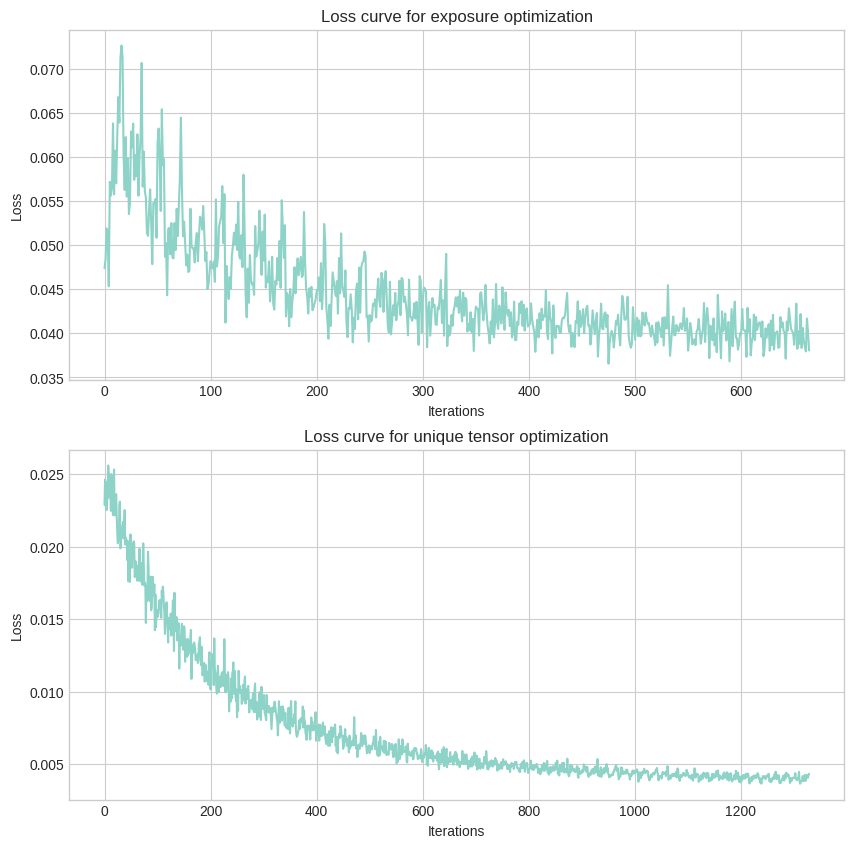

In [11]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(loss_list_exposure)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss curve for exposure optimization")

plt.subplot(2, 1, 2)
plt.plot(loss_list)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss curve for unique tensor optimization")

In [23]:
images = SH2RGB(latent_feats)[data_parser.unq_inv].reshape(N, H*W, -1) # N x HW x 3
# images = torch.bmm(images, exposure[:, :3, :3]) + exposure[:, None, :3, 3]
images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W
save_name = f"opt_lr_{feature_lr:3f}_lambda_flow_{lambda_flow}_lambda_exp_{lambda_exp}_ssim_{lambda_dssim}_conf_pix_slevel1_ep{epochs}_loss_{loss_list[-1]:.3f}"
cur_output_path = os.path.join(output_dir, save_name)
save_video(images, cur_output_path, save_frame=True)
# copy output_dir/config.yaml and output_dir/output_gt.gif to cur_output_path
os.system(f"cp {os.path.join(output_dir, 'config.yaml')} {cur_output_path}")
os.system(f"cp {os.path.join(output_dir, 'output_gt.gif')} {cur_output_path}")

[INFO] save video to ../workdir/sceneflow/sceneflow_highres_sky_lmr_0.2_gmr_0.1_vox_None/opt_lr_0.002667_lambda_flow_0.8_lambda_exp_0.8_ssim_0.2_conf_pix_slevel1_ep70_loss_0.004/output.gif


0

In [14]:
# coords_mask = ((coords_w.abs()[:, 0:1] > 50) & (coords_w.abs()[:, 1:2] > 50)).repeat(1, 3, 1, 1)
images = SH2RGB(latent_feats)[data_parser.unq_inv].reshape(N, H*W, -1) # N x HW x 3
images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W
# images[coords_mask] = 0

In [15]:
images_np = images.permute(0, 2, 3, 1).detach().cpu().numpy()
edited_images_np = dataset.edited_images.permute(0, 2, 3, 1).cpu().numpy()
# org_images_np = org_images.permute(0, 2, 3, 1).cpu().numpy()

(-0.5, 959.5, 511.5, -0.5)

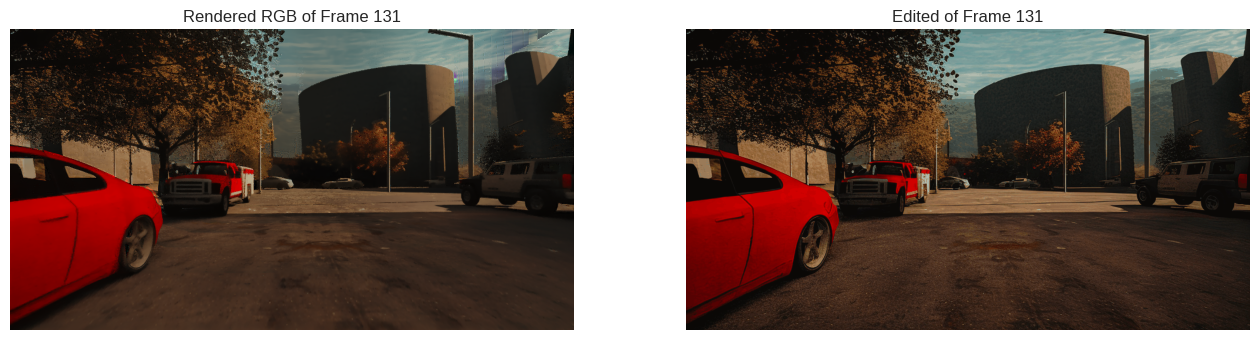

In [21]:
plt.style.use("seaborn-v0_8-whitegrid")
idx = random.randint(0, N-1)
# idx = 187
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(images_np[idx])
plt.title(f"Rendered RGB of Frame {idx}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edited_images_np[idx])
plt.title(f"Edited of Frame {idx}")
plt.axis("off")